In [38]:
import torch
import torchvision
from torchvision import transforms
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

class SegmentationDepthModel(torch.nn.Module):
    """
    A wrapper module that loads:
      - A lightweight semantic segmentation model (DeepLabV3 with a MobileNet V3 backbone)
      - A lightweight monocular depth estimation model (MiDaS_small)
    It accepts a PIL image in RGB and returns a dictionary with keys:
      'segmentation' and 'depth'
    """
    def __init__(self, device="cuda" if torch.cuda.is_available() else "cpu"):
        super().__init__()
        self.device = device

        # -------------------------------
        # Load Semantic Segmentation Model
        # -------------------------------
        # Load SegFormer pretrained on ADE20K
        self.seg_processor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        self.seg_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        self.seg_model.to(self.device).eval()


        # -------------------------------
        # Load Monocular Depth Estimation Model (MiDaS_small)
        # -------------------------------
        # Loading the small MiDaS model using torch.hub
        self.depth_model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
        self.depth_model.to(self.device)
        self.depth_model.eval()

        # Load MiDaS transforms (small_transform)
        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        self.depth_transform = midas_transforms.small_transform

    def forward(self, img):
        """
        Processes an input PIL image and returns both predictions.
        
        Args:
            img (PIL.Image): Input image in RGB format.
        
        Returns:
            dict: A dictionary with keys:
                - 'segmentation': A 2D NumPy array containing the semantic segmentation mask.
                - 'depth': A 2D NumPy array representing the estimated depth map.
        """
        # Remember the original image size.
        orig_width, orig_height = img.size

        # -------------------------------
        # Semantic Segmentation Path
        # -------------------------------
        seg_inputs = self.seg_processor(images=img, return_tensors="pt")
        seg_inputs = {k: v.to(self.device) for k, v in seg_inputs.items()}
        with torch.no_grad():
            seg_output = self.seg_model(**seg_inputs)
        seg_logits = seg_output.logits  # [1, num_classes, H, W]
        seg_preds = seg_logits.argmax(dim=1)[0].cpu().numpy()
        seg_prediction = cv2.resize(seg_preds.astype(np.uint8), (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)

        # -------------------------------
        # Monocular Depth Estimation Path
        # -------------------------------
        # Convert the PIL image to a NumPy array before passing to the transform.
        img_np = np.array(img)
        depth_input = self.depth_transform(img_np).to(self.device)
        with torch.no_grad():
            depth_out = self.depth_model(depth_input)  # Shape: [1, 256, 256]
            depth_out = depth_out.unsqueeze(1)  # Now shape: [1, 1, 256, 256]
        # Upsample depth output to the original image size
        print(f"Depth output shape: {depth_out.shape}")
        print(f"Original image size: {orig_height}, {orig_width}")
        # Upsample depth output to original size
        # Note: MiDaS outputs a single-channel depth map.
        # The depth map is resized to the original image size.
        depth_out = torch.nn.functional.interpolate(
            depth_out,
            size=(orig_height, orig_width),
            mode="bilinear",
            align_corners=False
        )
        depth_map = depth_out.squeeze().cpu().numpy()

        return {"segmentation": seg_prediction, "depth": depth_map}


In [39]:
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SegmentationDepthModel(device=device)

Using cache found in /Users/MohammedIbrahim/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/MohammedIbrahim/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /Users/MohammedIbrahim/.cache/torch/hub/intel-isl_MiDaS_master


Depth output shape: torch.Size([1, 1, 128, 256])
Original image size: 1024, 2048


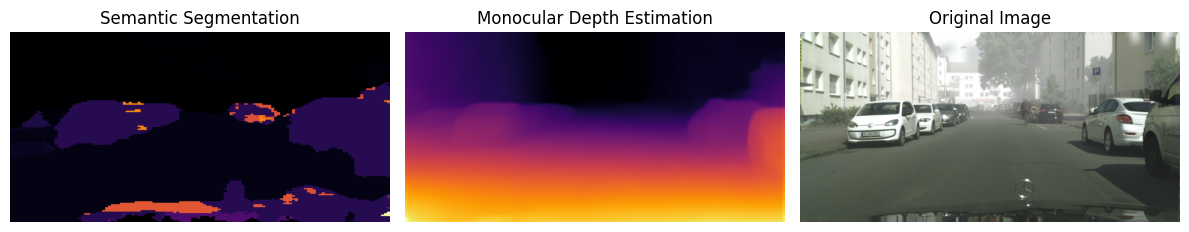

In [42]:
image_path = "dataset/RESIDE-6K/train/GT/2.jpg" 
image_path = "/Volumes/S/dev/project/code/Aphase/dehaze/dataset/foggy_data/Medium_Fog/002.png" 
img = Image.open(image_path).convert("RGB")

with torch.no_grad():
    outputs = model(img)
segmentation = outputs["segmentation"]
depth = outputs["depth"]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(segmentation, cmap="inferno")
plt.title("Semantic Segmentation")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(depth, cmap="inferno")
plt.title("Monocular Depth Estimation")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.tight_layout()
plt.show()

